**FOOD DETECTION USING  PYTORCH (ATTEMPT - 2)**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Necessary header files were included.

In [0]:
import torch
from engine import train_one_epoch, evaluate
import utils
import transforms as T
import torchvision.transforms as transforms
import torchvision
import torchvision.transforms.functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.utils.data
from PIL import Image, ImageFile
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches


ImageFile.LOAD_TRUNCATED_IMAGES = True

A function to perform tensor transformation

In [0]:
def get_transform():
    transforms = []
    transforms.append(T.ToTensor())
    return T.Compose(transforms)

A **Pretrained ResNet based Faster RCNN** model was obtained.
The idea behind this attempt was to use a pretrained model on object detection and  to fine tune it for the task of food detection. 

In [0]:
def get_instance_segmentation_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

A Dataset class was bulit using the Pytorch libraries to generate batches of the image along with its bounding box and class informations iteratively.

In [0]:
import collections
import os
import numpy as np


class OpenDataset(torch.utils.data.Dataset):
    def __init__(self, height=512, width=512, transforms=None):
        self.transforms = transforms
        imgs_path=[]
        with open("drive//My Drive//food images//images.txt",'r') as f:
          for i in f.readlines():
            imgs_path.append(i[:-1])
        self.imgs_path=imgs_path
        bb=[]
        with open("drive//My Drive//food images//bb_inf.txt",'r') as f:
          for i in f.readlines():
            #print(eval(i)[0])
            bb.append(eval(i))
        self.bb=bb
        class_names=open("drive//My Drive//food images//classes.txt",'r').readlines()
        self.class_names=[class_names[i][:-1] for i in range(len(class_names))]
        self.height = height
        self.width = width
        

    def __getitem__(self, idx):
        img_path = "drive//My Drive//food images//"+self.imgs_path[idx]
        img = Image.open(img_path).convert("RGB")
        #img = img.resize((self.width, self.height), resample=Image.BILINEAR)
        
        # processing part and extraction of boxes is left as an exercise to the reader
        boxes=[]
        labels=torch.zeros((len(self.bb[idx][1])))
        a=[]
        i=0
        for b in self.bb[idx][1]:
          labels[i]=int(b[0])-1
          xmin=(b[1]-b[3]/2)*512/800
          ymin=(b[2]-b[4]/2)*512/600
          xmax=(b[1]+b[3]/2)*512/800
          ymax=(b[2]+b[4]/2)*512/600
          a.append(b[3]*b[4])
          boxes.append([xmin,ymin,xmax,ymax])
          i+=1
        target = {}
        target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])
        target["area"]=torch.as_tensor(a,dtype=torch.float32)
        target["iscrowd"]=torch.zeros((len(self.bb[idx][1])))
        target=[target]
        #img=[img]
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs_path)

A function to plot the image along with its bounding box was defined.

In [0]:
def plot_bb(img, targ):
  fig,ax=plt.subplots(1)
  img=img.permute(1,2,0).numpy()
  #print(img.shape)
  ax.imshow(img)
  for i in range(len(targ["boxes"])):
    lab=int(targ["labels"][i])
    b=targ["boxes"][i]
    x,y=b[0],b[1]
    w,h=b[2]-b[0],b[3]-b[1]
    bb=patches.Rectangle((x,y),w,h,edgecolor='b',fill=False)
    ax.add_patch(bb)
    plt.text(x,y,lab,fontsize=15,color='b')
  plt.show()

Sample images from the Dataset class were used to plot images.

torch.Size([3, 512, 512])
[{'boxes': tensor([[  0.0000, 122.0267, 236.8000, 414.7200],
        [232.3200,  77.6533, 512.0000, 477.8667]]), 'labels': tensor([ 0., 41.]), 'image_id': tensor([0]), 'area': tensor([126910., 204953.]), 'iscrowd': tensor([0., 0.])}]
torch.Size([2, 4])
torch.Size([2])
torch.Size([1])
torch.Size([2])
torch.Size([2])


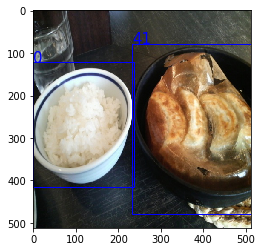

In [0]:
data=OpenDataset(transforms=get_transform())
img,targ=next(iter(data))
print(img.size())
print([t for t in targ])
print(targ[0]["boxes"].size())
print(targ[0]["labels"].size())
print(targ[0]["image_id"].size())
print(targ[0]["area"].size())
print(targ[0]["iscrowd"].size())
plot_bb(img,targ[0])

A function to train the pretrained model of **Faster RCNN**.

In [0]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(images.to(device))
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])



This attempted failed due to an error which occured continuously.

In [0]:
num_classes = 100
device = torch.device('cuda:0')
dataset_train = OpenDataset(transforms=get_transform())

model_ft = get_instance_segmentation_model(num_classes)
model_ft.to(device)

data_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=1, shuffle=True)

params = [p for p in model_ft.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=5,
                                               gamma=0.1)
num_epochs = 100
for epoch in range(num_epochs):
    train_one_epoch(model_ft, optimizer, data_loader, device, epoch, print_freq=1)
    lr_scheduler.step()

#torch.save(model_ft.state_dict(), "model.bin")

ValueError: ignored